In [17]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Model
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Add, Activation, LSTM
from keras.optimizers import Adam
import matplotlib.pyplot as plt

In [18]:
# Access Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
# Load datasets
bitcoin_data_path = '/content/drive/MyDrive/dataset/Bitcoin Historical Data.csv'
nasdaq_data_path = '/content/drive/MyDrive/dataset/NASDAQ Composite Historical Data.csv'
usd_data_path = '/content/drive/MyDrive/dataset/US Dollar Index Futures Historical Data.csv'

In [20]:
# Define a function to preprocess each dataset
def preprocess_data(data_path, date_format='%d/%m/%Y'):
  df = pd.read_csv(data_path)
  df = df[::-1] # Reverse the order
  df.fillna(method='ffill', inplace=True)
  df['Price'] = df['Price'].str.replace(',', '').astype(float)
  df['Date'] = pd.to_datetime(df['Date'], format=date_format)
  return df

In [21]:
# Define a function to preprocess each dataset
def preprocess_us_data(data_path, date_format='%m/%d/%Y'):
    df = pd.read_csv(data_path)
    df = df[::-1]  # Reverse the order
    df.fillna(method='ffill', inplace=True)
    df['Date'] = pd.to_datetime(df['Date'], format=date_format)
    return df

In [22]:
# Preprocess each dataset
bitcoin_df = preprocess_data(bitcoin_data_path)
nasdaq_df = preprocess_data(nasdaq_data_path)
usd_df = preprocess_us_data(usd_data_path)

In [23]:
# Define a function to create sequences and perform forecasting
def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:i+sequence_length]
        y = data[i+sequence_length][0]  # Predicting 'Price'
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [24]:
def rolling_forecast_future(model, data, steps, scaler, window_size=30):
    forecast = []
    last_sequence = data[-window_size:]

    for _ in range(steps // window_size):
        predictions = []

        for _ in range(window_size):
            prediction = model.predict(last_sequence.reshape(1, last_sequence.shape[0], last_sequence.shape[1]))
            predictions.append(prediction[0][0])
            last_sequence = np.roll(last_sequence, -1, axis=0)
            last_sequence[-1, 0] = prediction[0][0]

        forecast.extend(predictions)

    forecast = np.array(forecast)
    forecast_with_features = np.zeros((forecast.shape[0], data.shape[1]))
    forecast_with_features[:, 0] = forecast  # Fill in the 'Price' predictions

    forecast_with_features = scaler.inverse_transform(forecast_with_features)
    forecast_prices = forecast_with_features[:, 0]  # Extract the 'Price' column

    return forecast_prices

In [25]:
# Function to split data into training and testing sets
def split_data(X, y, ratio):
    train_size = int(len(X) * ratio)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    return X_train, X_test, y_train, y_test

In [26]:
def build_res_cnn_block(input_layer):
    conv1 = Conv1D(filters=64, kernel_size=2, padding='same', activation='relu')(input_layer)
    conv1 = MaxPooling1D(pool_size=2)(conv1)
    conv2 = Conv1D(filters=64, kernel_size=2, padding='same', activation='relu')(conv1)
    conv2 = Conv1D(filters=64, kernel_size=2, padding='same', activation='linear')(conv2)
    skip_connection = Add()([conv1, conv2])
    skip_connection = Activation('relu')(skip_connection)
    return skip_connection

In [27]:
def build_rescnn_lstm_model(input_shape):
    input_layer = Input(shape=input_shape)
    res_cnn_block1 = build_res_cnn_block(input_layer)
    res_cnn_block2 = build_res_cnn_block(res_cnn_block1)
    lstm_layer = LSTM(64, return_sequences=False)(res_cnn_block2)
    dense1 = Dense(32, activation='relu')(lstm_layer)
    output_layer = Dense(1, activation='linear')(dense1)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

In [28]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, epochs=1):
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_test, y_test))
    predicted_prices = model.predict(X_test).flatten()
    mae = mean_absolute_error(y_test, predicted_prices)
    rmse = np.sqrt(mean_squared_error(y_test, predicted_prices))
    mape = np.mean(np.abs((y_test - predicted_prices) / y_test)) * 100
    return predicted_prices, mae, rmse, mape

In [29]:
# Chia dữ liệu thành ba pha
ratios = [0.7, 0.8, 0.6]
results = {}

1/1 [==============================] - 0s 21ms/step


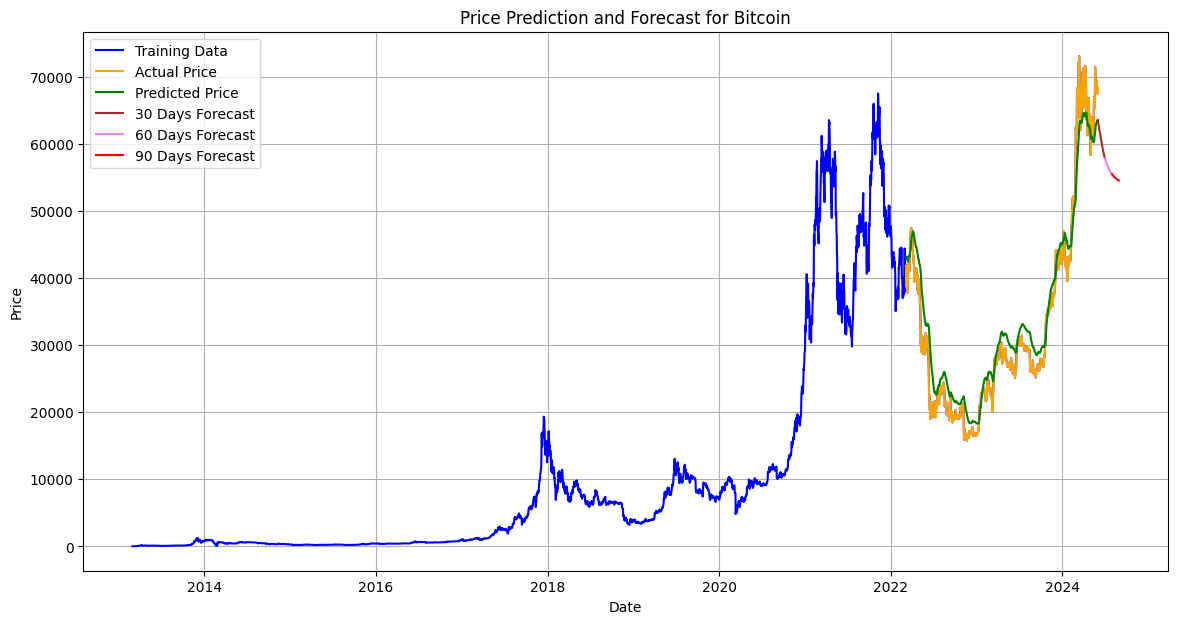

1/1 [==============================] - 0s 20ms/step


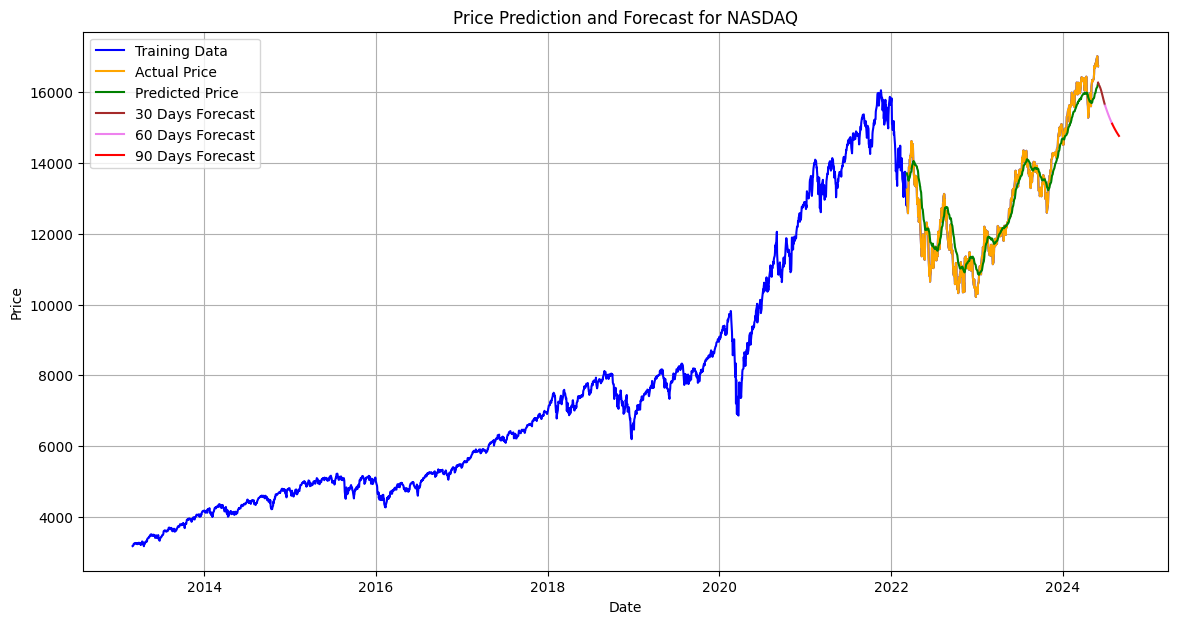

1/1 [==============================] - 0s 19ms/step


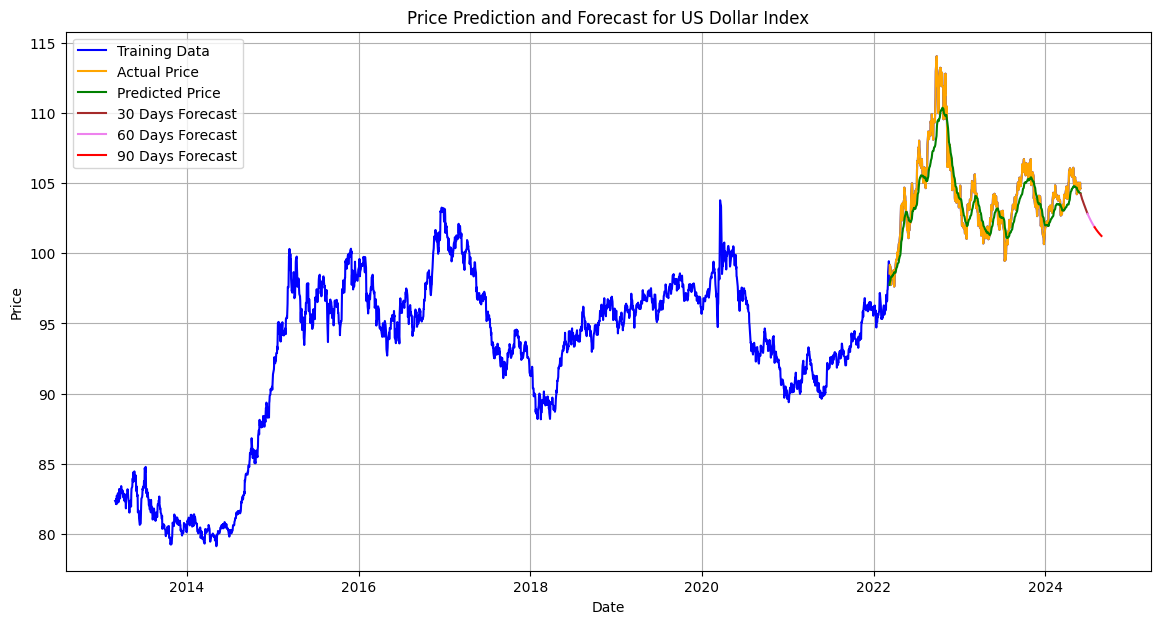

Bitcoin Results: MAE: 0.038203549904059386, RMSE: 0.046797393287853484, MAPE: 9.510758264708567
NASDAQ Results: MAE: 0.02777535061993092, RMSE: 0.034440605441012774, MAPE: 4.052633756198886
US Dollar Index Results: MAE: 0.029393837171692822, RMSE: 0.037181640216143036, MAPE: 3.961758694014355


In [30]:
def process_dataset(df, dataset_name):
    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df[['Price']])

    # Create sequences
    sequence_length = 30
    X, y = create_sequences(scaled_data, sequence_length)

    # Split data
    X_train, X_test, y_train, y_test = split_data(X, y, 0.8)

    # Build and train model
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = build_rescnn_lstm_model(input_shape)
    predicted_prices, mae, rmse, mape = train_and_evaluate_model(model, X_train, y_train, X_test, y_test, epochs=1)

    # Inverse transform to get actual prices
    y_test_reshaped = y_test.reshape(-1, 1)
    predicted_prices_reshaped = predicted_prices.reshape(-1, 1)
    actual_prices = scaler.inverse_transform(np.hstack((y_test_reshaped, np.zeros((y_test_reshaped.shape[0], scaled_data.shape[1]-1)))))[:, 0]
    predicted_prices_actual = scaler.inverse_transform(np.hstack((predicted_prices_reshaped, np.zeros((predicted_prices_reshaped.shape[0], scaled_data.shape[1]-1)))))[:, 0]

    # Plot results
    plt.figure(figsize=(14, 7))
    plt.plot(df['Date'], df['Price'], color='blue', label='Training Data', linestyle='solid')
    plt.plot(df['Date'][len(df) - len(y_test):], actual_prices, color='orange', label='Actual Price', linestyle='solid')
    plt.plot(df['Date'][len(df) - len(y_test):], predicted_prices_actual, color='green', label='Predicted Price', linestyle='solid')

    # Rolling forecast future prices
    forecast_30 = rolling_forecast_future(model, scaled_data, 30, scaler)
    forecast_60 = rolling_forecast_future(model, scaled_data, 60, scaler)
    forecast_90 = rolling_forecast_future(model, scaled_data, 90, scaler)

    forecast_dates_30 = pd.date_range(start=df['Date'].iloc[-1], periods=30, freq='D')
    forecast_dates_60 = pd.date_range(start=df['Date'].iloc[-1], periods=60, freq='D')
    forecast_dates_90 = pd.date_range(start=df['Date'].iloc[-1], periods=90, freq='D')

    plt.plot(forecast_dates_30, forecast_30, color='brown', label='30 Days Forecast', linestyle='solid')
    plt.plot(forecast_dates_60[30:], forecast_60[30:], color='violet', label='60 Days Forecast', linestyle='solid')
    plt.plot(forecast_dates_90[60:], forecast_90[60:], color='red', label='90 Days Forecast', linestyle='solid')

    plt.title(f'Price Prediction and Forecast for {dataset_name}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    return {'mae': mae, 'rmse': rmse, 'mape': mape}

# Process each dataset separately
bitcoin_results = process_dataset(bitcoin_df, 'Bitcoin')
nasdaq_results = process_dataset(nasdaq_df, 'NASDAQ')
usd_results = process_dataset(usd_df, 'US Dollar Index')

# Print results
print(f'Bitcoin Results: MAE: {bitcoin_results["mae"]}, RMSE: {bitcoin_results["rmse"]}, MAPE: {bitcoin_results["mape"]}')
print(f'NASDAQ Results: MAE: {nasdaq_results["mae"]}, RMSE: {nasdaq_results["rmse"]}, MAPE: {nasdaq_results["mape"]}')
print(f'US Dollar Index Results: MAE: {usd_results["mae"]}, RMSE: {usd_results["rmse"]}, MAPE: {usd_results["mape"]}')


1/1 [==============================] - 0s 43ms/step


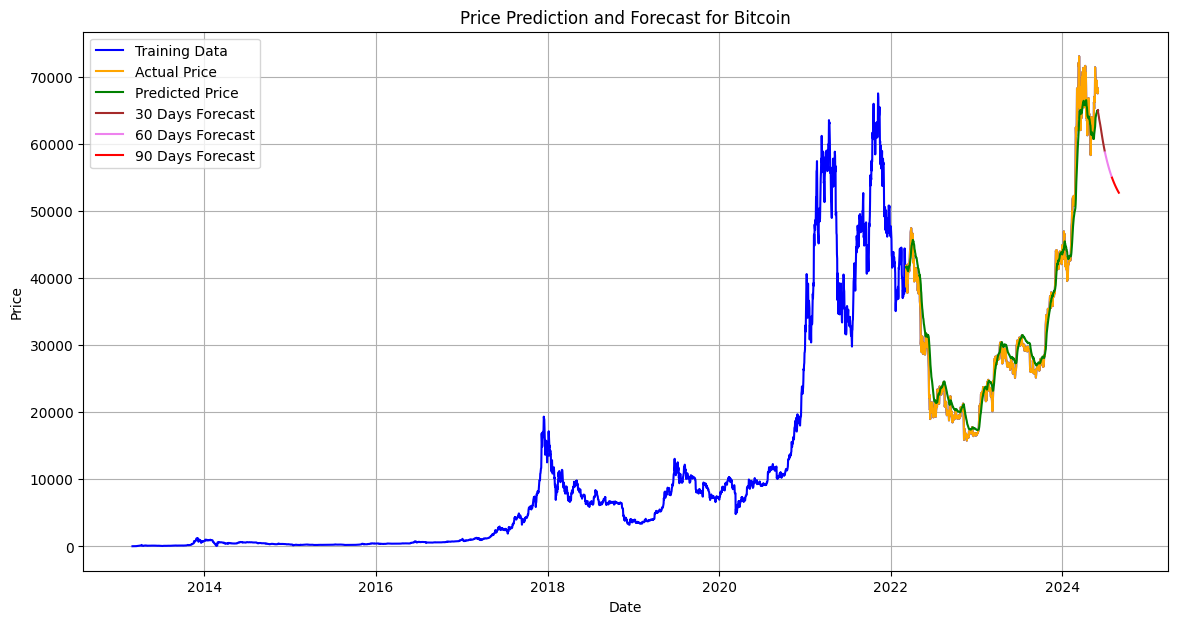

1/1 [==============================] - 0s 20ms/step


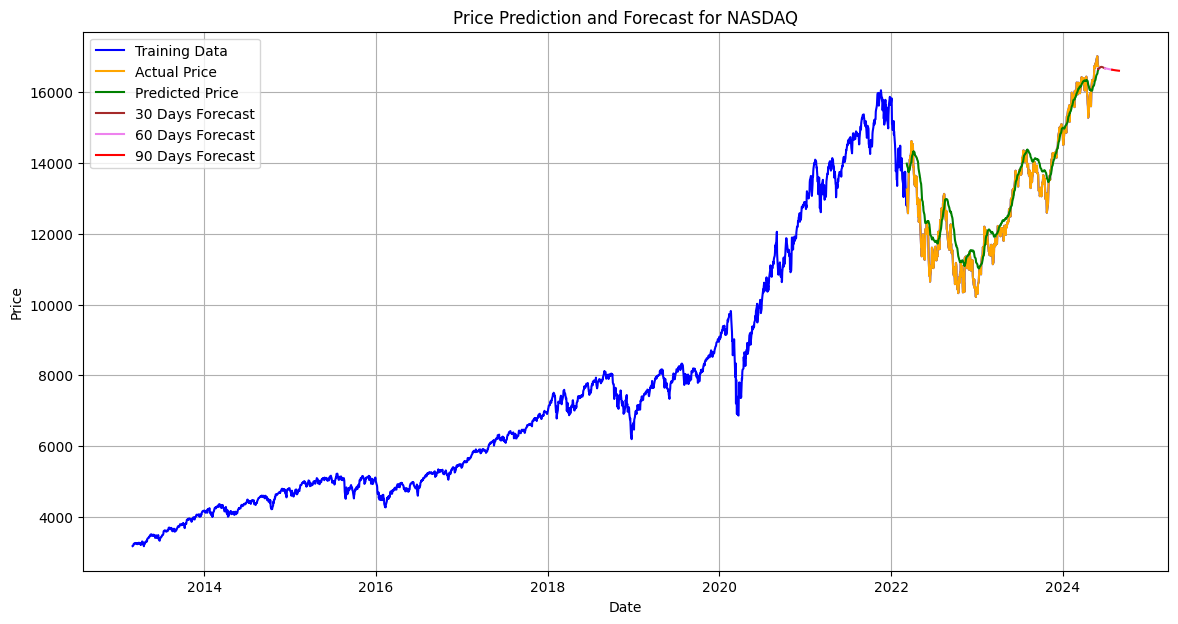

1/1 [==============================] - 0s 20ms/step


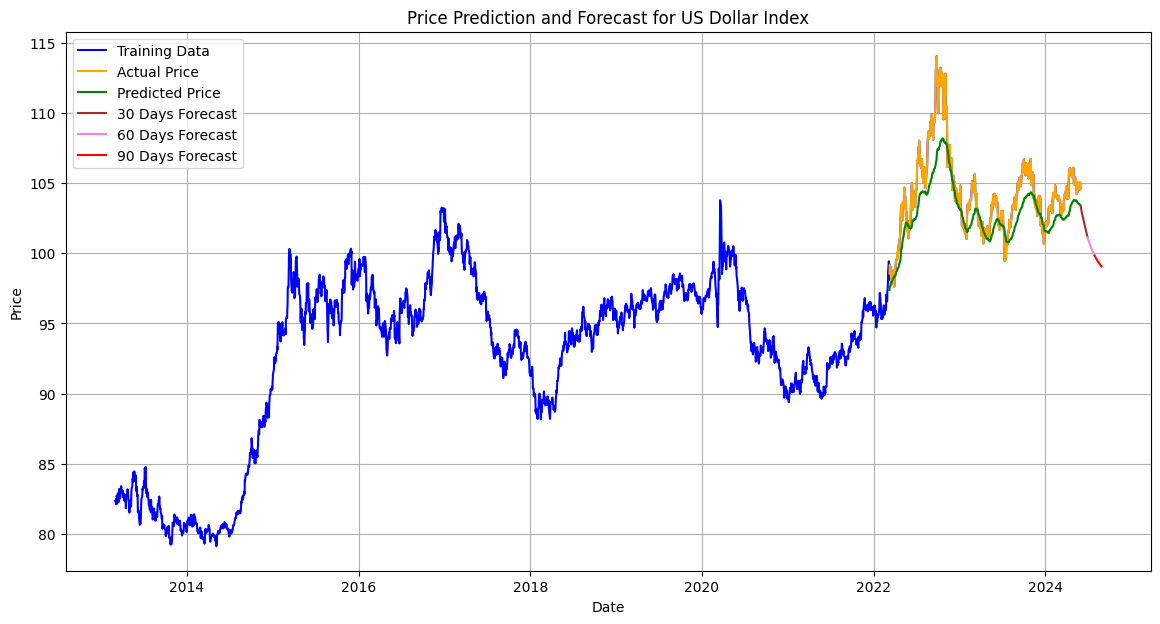

Bitcoin Results: MAE: 0.025136578233005073, RMSE: 0.034895313208058255, MAPE: 5.917488334191031
NASDAQ Results: MAE: 0.029308005560274516, RMSE: 0.03906726605882629, MAPE: 4.495287208497498
US Dollar Index Results: MAE: 0.04355704186452344, RMSE: 0.05556658107400522, MAPE: 5.743832774778265


In [31]:
# Process each dataset separately
bitcoin_results = process_dataset(bitcoin_df, 'Bitcoin')
nasdaq_results = process_dataset(nasdaq_df, 'NASDAQ')
usd_results = process_dataset(usd_df, 'US Dollar Index')

# Print results
print(f'Bitcoin Results: MAE: {bitcoin_results["mae"]}, RMSE: {bitcoin_results["rmse"]}, MAPE: {bitcoin_results["mape"]}')
print(f'NASDAQ Results: MAE: {nasdaq_results["mae"]}, RMSE: {nasdaq_results["rmse"]}, MAPE: {nasdaq_results["mape"]}')
print(f'US Dollar Index Results: MAE: {usd_results["mae"]}, RMSE: {usd_results["rmse"]}, MAPE: {usd_results["mape"]}')